# Flight Path Analysis
This notebook evaluates the origins and destinations of flights in the two periods of: 
* Jan - July 2019
* Jan - July 2020

We retrieved monthly data for international and domestic markets from the US Department of Transportation, Bureau of Transporation Statistics. The data has monthly summaries of passengers with origins and destinations of the flights taken each month and is only current through July 2020. For this reason, we limited our analysis to compare only January to July in 2019 and 2020.

Data Source: [Air Carriers: T-100 Market (All Carriers) from the Bureau of Transportation Statistics, US Department of Transporation](https://www.transtats.bts.gov/Tables.asp?DB_ID=111&DB_Name=Air%20Carrier%20Statistics%20%28Form%2041%20Traffic%29-%20All%20Carriers&DB_Short_Name=Air%20Carriers) 


In this notebook, we will use the Independent T Test and various plots to evaluate the following hypotheses:

**Null Hypothesis** - There is no statistical significance in the percent change of passengers flying to domestic and international destinations in 2019 and 2020. 

**Alternative Hypothesis** - There is a statistical significance in the percent change of passengers flying to domestic and international destinations in 2019 and 2020.

## Summary Analysis

* We can see that the majority of flights saw a substantial decrease in passengers. More than 6000 flights saw a 50 to 75% decrease in passengers. For example, the flight with the most passengers in 2019 saw a significant decrease in passengers between February and March of 2020.


* We ran a linear regression and correlation analysis comparing the flight distance and percent change in passengers. The correlation coefficient is -0.03 shows a very weak negative correlation between flight distance and precent change in the number of passengers.


* We ran an Independent T Test looking at flights destined for the US versus flights destined for other countries.This test showed a very high statistical significance in the difference between the percent change of passengers on these flights with a pvalue of 0.0045.
 
These findings confirm the Alternative Hypothesis that there is a statistical significance in the percent change of passengers flying to domestic and international locations in 2019 and 2020.



In [1]:
#import dependencies
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox
import pandas as pd
import scipy.stats as stats
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress

#get data
flightdata = pd.read_csv('output_data/flightdata.csv')

## Percent Change in Passengers on Flights from 2019 to 2020

In [2]:
flightchangesgrp = flightdata.groupby(['flight','YEAR'], as_index = False).agg({'PASSENGERS':'sum'})
flightchanges = pd.DataFrame(flightchangesgrp.pivot(index='flight', columns='YEAR', values='PASSENGERS').fillna(0))
flightchanges['% Δ'] = flightchanges.pct_change(axis='columns').iloc[:, -1]

# drop infinity and na values
flightchanges = flightchanges.loc[(flightchanges['% Δ']!=float("inf")),:].dropna(subset=['% Δ'])

# create bins for % change categories
binlabels = ['-76 to -100% Δ', '-51 to -75% Δ', '-26 to -50% Δ', '-1 to -25% Δ','No Δ','1 to 100% Δ', '> 100% Δ']
cut_bins = [-1,-0.75,-0.5,-0.25,-0.01,0.01,1,float("inf")]

# add column and calculate category
flightchanges['Δ Category'] = pd.cut(flightchanges['% Δ'], bins=cut_bins, labels=binlabels)

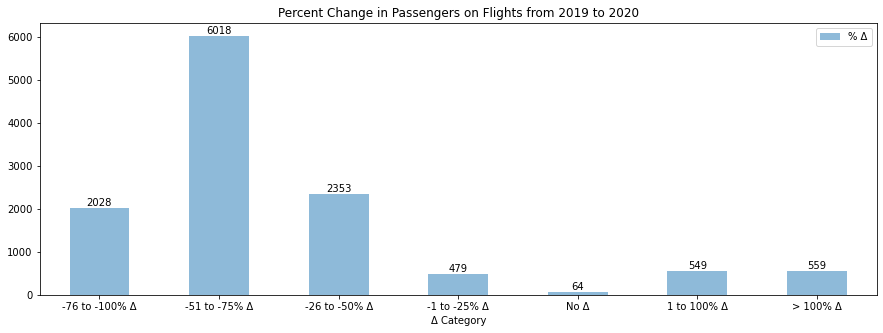

In [3]:
summarychangesgrp = flightchanges.groupby('Δ Category').agg({'% Δ':'count'}) 

summary_changes_bar = summarychangesgrp.plot.bar(figsize=(15,5), alpha=0.5, align="center", title="Percent Change in Passengers on Flights from 2019 to 2020")
summary_changes_bar.set_xticklabels(summarychangesgrp.index, rotation=0)
for bar in summary_changes_bar.patches:
    summary_changes_bar.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    xytext=(0, 5), 
                   textcoords='offset points')
plt.savefig("images/PercentChangeInFlightPassengers2019-2020.png")

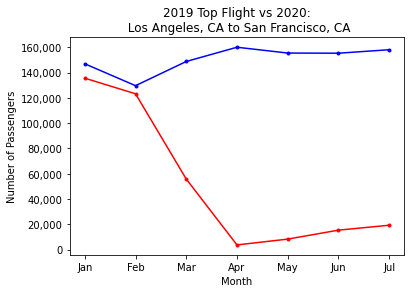

In [4]:
# get flight that had the most passengers in 2019 and saw the greatest decrease 
# plot as line charts with pct_change over months for 2019 and 2020

# top flight in 2019
topflight = flightchanges.sort_values(by=[2019,'% Δ'], ascending=[False,True]).head(1)

mthly_flightchangesgrp = flightdata.groupby(['flight','ORIGIN_CITY_NAME','DEST_CITY_NAME','YEAR','MONTH'], as_index = False).agg({'PASSENGERS':'sum'})
mthly_flightchangesgrp.columns
mthly_flightchangesgrp

# # get data for jan - july passengers in each year from original df
topflight_ext = topflight.merge(mthly_flightchangesgrp, how='inner', on='flight')
topflight_ext

# set x_axis for line plot
x_axis = np.arange(1,8,1)
passengers2019 = topflight_ext.loc[topflight_ext['YEAR']==2019,'PASSENGERS']
passengers2020 = topflight_ext.loc[topflight_ext['YEAR']==2020,'PASSENGERS']
monthlist = ['Jan','Feb','Mar','Apr','May','Jun','Jul']

# create figure with subplots for two lines and plot lines with a secondary y axis and axis titles color coded to line color instead of legend
fig2, ax1 = plt.subplots()
ax1.plot(x_axis,passengers2019, marker='.', color='blue', label='2019 Passengers')
ax1.set_title(f"2019 Top Flight vs 2020:\n {topflight_ext['ORIGIN_CITY_NAME'].iloc[0]} to {topflight_ext['DEST_CITY_NAME'].iloc[0]}")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Passengers")
ax1.plot(x_axis,passengers2020, marker='.', color='red', label='2020 Passengers')
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(x_axis,monthlist)
plt.savefig("images/TopFlightPassengersByMonth2019-2020.png")
plt.show()

### T Tests

In [5]:
statsgrp = flightdata.groupby(['flight','ORIGIN_COUNTRY_NAME','DEST_COUNTRY_NAME'], as_index = False).agg({'DISTANCE':'mean'})

# merge statsgrp with flight changes to get delta and distance together
statsdata = statsgrp.merge(flightchanges, how='inner', on='flight')

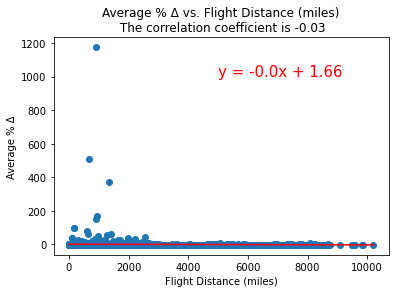

In [6]:
# linear regression for distance vs avg percent change

linregdata = statsdata.groupby('DISTANCE', as_index = False).agg({'% Δ':'mean'})

x_values = linregdata["DISTANCE"]
y_values = linregdata["% Δ"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# calculate correlation
correlation = stats.pearsonr(x_values,y_values)

# add to previous plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5000,1000),fontsize=15,color="red")
plt.title(f"Average % Δ vs. Flight Distance (miles)\n The correlation coefficient is {round(correlation[0],2)}")
plt.xlabel('Flight Distance (miles)')
plt.ylabel('Average % Δ')

# save fig
plt.savefig("images/LineRegress_Correlation_Distance_PercentChange.png")
plt.show()


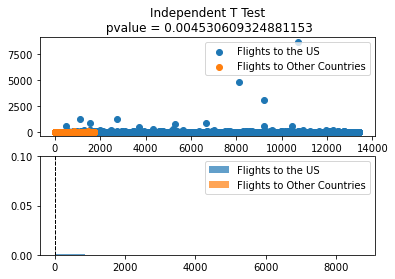

In [7]:
#independent t test comparing flights to the US and flights to other countries
population1 = statsdata[statsdata['DEST_COUNTRY_NAME']=='United States']['% Δ']
population2 = statsdata[statsdata['DEST_COUNTRY_NAME']!='United States']['% Δ']

# Calculate Independent (Two Sample) t-test
result = stats.ttest_ind(population1, population2, equal_var=False)

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(population1)), population1, label="Flights to the US")
plt.scatter(range(len(population2)), population2, label="Flights to Other Countries")
plt.legend()
plt.title(f'Independent T Test\n pvalue = {result[1]}')

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(population1, 10, density=True, alpha=0.7, label="Flights to the US")
plt.hist(population2, 10, density=True, alpha=0.7, label="Flights to Other Countries")
plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend() 

# save fig
plt.savefig("images/IndTTest_DestinationComparison.png")
plt.show()

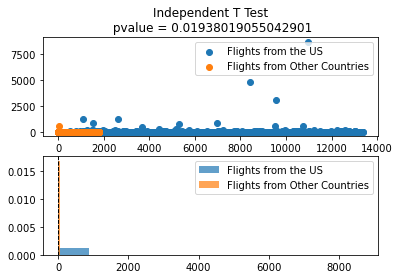

In [8]:
#independent t test comparing flights from the US and flights from other countries
population1 = statsdata[statsdata['ORIGIN_COUNTRY_NAME']=='United States']['% Δ']
population2 = statsdata[statsdata['ORIGIN_COUNTRY_NAME']!='United States']['% Δ']

# Calculate Independent (Two Sample) t-test
result = stats.ttest_ind(population1, population2, equal_var=False)

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(population1)), population1, label="Flights from the US")
plt.scatter(range(len(population2)), population2, label="Flights from Other Countries")
plt.legend()
plt.title(f'Independent T Test\n pvalue = {result[1]}')

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(population1, 10, density=True, alpha=0.7, label="Flights from the US")
plt.hist(population2, 10, density=True, alpha=0.7, label="Flights from Other Countries")
plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend() 

# save fig
plt.savefig("images/IndTTest_OriginComparison.png")
plt.show()